# **Predicting NBA MVP**

**📍 Contributors**
<br>
- Evgeny Smirnov
- Matteo Torlone
- Steven Wilson

<br>
The objective of this project is to develop a predictive model that can accurately forecast the Most Valuable Player (MVP) of the NBA based on a combination of individual player performance metrics, team performance metrics, and other relevant factors.

### **Imports and Models**

In [ ]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from time import time
import warnings
warnings.filterwarnings('ignore')

# Defining seasons and models to be used
season = '2021-22'
skModels = ['SVM','Random Forest','Gradient Boosting']

### **Extract Data**

In [ ]:

# Data hosted on GitHub
url_per_game = "https://raw.githubusercontent.com/steven-n-wilson/NBA-MVP/main/data/2021-22%20Per%20Game.csv"
url_total = "https://raw.githubusercontent.com/steven-n-wilson/NBA-MVP/main/data/2021-22%20Total.csv"
url_advanced = "https://raw.githubusercontent.com/steven-n-wilson/NBA-MVP/main/data/2021-22%20Advanced.csv"
url_standings = "https://raw.githubusercontent.com/steven-n-wilson/NBA-MVP/main/data/2021-22%20Standings.csv"
url_mvps = "https://raw.githubusercontent.com/steven-n-wilson/NBA-MVP/main/data/MVPs.csv"

# Initializing dataframes
per_game = pd.read_csv(url_per_game)
total = pd.read_csv(url_total)
advanced = pd.read_csv(url_advanced)
standings = pd.read_csv(url_standings)
mvps = pd.read_csv(url_mvps)


### **Transform Data**

In [ ]:
def transform_data(per_game, total, advanced, standings, mvps):

  # Removing duplicate columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    total = total.drop(['Rk','Pos','Age','G','GS'], axis=1)
    advanced = advanced.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19'], axis=1) # also removes blank columns

    columns = ['Player','Season','Pos','Age','Tm','G','GS']

  # Identifying and renaming table specfic columns
    for col in per_game.columns:
      if col not in columns:
        new_column = col + "_PERGAME"
        per_game = per_game.rename(columns={col:new_column})

    for col in total.columns:
      if col not in columns:
        new_column = col + "_TOTAL"
        total = total.rename(columns={col:new_column})

    for col in advanced.columns:
      if col not in columns:
        new_column = col + "_ADVANCED"
        advanced = advanced.rename(columns={col:new_column})

  # Merging dataframes (per_game, advanced, total)
    data = per_game.merge(advanced, on=['Player', 'Tm'], how='left', validate='1:1')
    data = data.merge(total, on=['Player', 'Tm'], how='left', validate='1:1')

  # Dictionary of NBA teams with their corresponding abbreviations
    dict_teams = {
        'Utah Jazz': 'UTA', 'Phoenix Suns': 'PHO', 'Philadelphia 76ers': 'PHI', 'Brooklyn Nets': 'BRK',
        'Denver Nuggets': 'DEN', 'Los Angeles Clippers': 'LAC', 'Milwaukee Bucks': 'MIL', 'Dallas Mavericks': 'DAL',
        'Los Angeles Lakers': 'LAL', 'Portland Trail Blazers': 'POR', 'Atlanta Hawks': 'ATL', 'New York Knicks': 'NYK',
        'Miami Heat': 'MIA', 'Golden State Warriors': 'GSW', 'Memphis Grizzlies': 'MEM', 'Boston Celtics': 'BOS',
        'Washington Wizards': 'WAS', 'Indiana Pacers': 'IND', 'Charlotte Hornets': 'CHO', 'Charlotte Bobcats': 'CHA',
        'San Antonio Spurs': 'SAS', 'Chicago Bulls': 'CHI', 'New Orleans Pelicans': 'NOP', 'Sacramento Kings': 'SAC',
        'Toronto Raptors': 'TOR', 'Minnesota Timberwolves': 'MIN', 'Cleveland Cavaliers': 'CLE',
        'Oklahoma City Thunder': 'OKC', 'Orlando Magic': 'ORL', 'Detroit Pistons': 'DET', 'Houston Rockets': 'HOU',
        'New Jersey Nets': 'NJN', 'New Orleans Hornets': 'NOH', 'Seattle SuperSonics': 'SEA'
    }

  # Creates a datframe for teams and abbreviations
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team', 0:'Tm'}) # changes the names of the columns

  # Merge dataframes (standings, teams)
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')

    wins = standings['Record'].str.split('-', expand=True)[0].astype(int) # extracts wins from dataframe
    losses = standings['Record'].str.split('-', expand=True)[1].astype(int) # extracts losses from dataframe
    total_games = wins + losses
    standings['PCT'] = wins / total_games # Calculates the percentage of wins during the season

  # Merge dataframes (data, standings)
    data = data.merge(standings, on=['Tm'], how='left', validate='m:1')

    mvps = mvps[mvps['Season'] == season] # from the mvps data frame, we need to select only the players from the desired season.
    data = data.merge(mvps, on=['Player'], how='left', validate='m:1').fillna(0) # fillna(0) method is used to fill missing (na) values with a specified value, in this case, 0.

    data['Player'] = data['Player'].str.split('\\', expand=True)[0] # this lines cleans the name formatting: Nikola Jokić\jokicni01 -> Nikola Jokić

  # Removes duplicate lines from injured players or transfers
    data = data.drop_duplicates(subset='Player', keep='first')


  # Filter to identify players who meet or exceed certain statistical thresholds that are
  # commonly associated with MVP-caliber performances

  # # ** TIGHT FILTER **
  #   data = data[
  #       (
  #           # Player must have played a significant portion of the season
  #           (data['G'] > 48) &
  #           # MVP candidates often lead their teams in scoring
  #           (data['PTS_PERGAME'] > 20) &
  #           # MVP candidates typically play significant minutes
  #           (data['MP_PERGAME'] > 30) &
  #           # MVP candidates often come from top-seeded teams
  #           (data['Seed'] <= 4) &
  #           # MVP candidates are often strong playmakers
  #           (data['AST_PERGAME'] > 7) &
  #           # MVP candidates are usually strong rebounders
  #           (data['TRB_PERGAME'] > 7) &
  #           # Players must have played for a specific team (not traded mid-season)
  #           (data['Tm'] != 'TOT') &
  #           # MVP candidates typically have a high field goal percentage
  #           (data['FG%_PERGAME'] > 0.37) &
  #           # MVP candidates often attempt a significant number of field goals
  #           (data['FGA_PERGAME'] > 10) &
  #           # MVP candidates typically have high Player Efficiency Ratings
  #           (data['PER_ADVANCED'] > 20)
  #       ) |
  #       # Players who received MVP votes share above 5% are considered strong candidates
  #       (data['MVP Votes Share'] > 0.05)
  #   ].reset_index(drop=True)


  # # ** LOOSE FILTER **
  #   data = data[
  #     (
  #         (data['G'] > 48) &
  #         (data['PTS_PERGAME'] > 13.5) &
  #         (data['MP_PERGAME'] > 30) &
  #         (data['Seed'] <= 16) &
  #         (data['AST_PERGAME'] > 1) &
  #         (data['TRB_PERGAME'] > 3) &
  #         (data['Tm'] != 'TOT') &
  #         (data['FG%_PERGAME'] > 0.37) &
  #         (data['FGA_PERGAME'] > 10) &
  #         (data['PER_ADVANCED'] > 18)
  #     ) | (data['MVP Votes Share'] > 0)
  # ].reset_index(drop=True)

    # Removes unecessary team information
    data = data.drop(['Tm','Team','Record'], axis=1)

    # Generate sequential surrogate keys starting from 1
    data['Surrogate_Key'] = range(1, len(data) + 1)
    data.insert(0, 'Surrogate_Key', data.pop('Surrogate_Key')) # reorder Surrogate_Key column as the first column

    return data

In [ ]:
data = transform_data(per_game, total, advanced, standings, mvps)

# Generate CSV
# data.to_csv('data.csv', index=False)  # Set index=False to exclude the index from the CSV

data.head(10)

,Surrogate_Key,Player,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,...,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Rank,MVP Votes Share,Season
0,1,Precious Achiuwa,22,73,28,23.6,3.6,8.3,0.439,0.8,...,37,41,84,151,664,11.0,0.585366,0,0.0,0
1,2,Steven Adams,28,76,75,26.3,2.8,5.1,0.547,0.0,...,65,60,115,153,528,2.0,0.682927,0,0.0,0
2,3,Bam Adebayo,24,56,56,32.6,7.3,13.0,0.557,0.0,...,80,44,148,171,1068,4.0,0.646341,0,0.0,0
3,4,Santi Aldama,21,32,0,11.3,1.7,4.1,0.402,0.2,...,6,10,16,36,132,2.0,0.682927,0,0.0,0
4,5,LaMarcus Aldridge,36,47,12,22.3,5.4,9.7,0.550,0.3,...,14,47,44,78,607,14.0,0.536585,0,0.0,0
5,6,Nickeil Alexander-Walker,23,65,21,22.6,3.9,10.5,0.372,1.6,...,46,23,93,103,692,0.0,0.000000,0,0.0,0
8,7,Grayson Allen,26,66,61,27.3,3.9,8.6,0.448,2.4,...,46,18,43,96,733,7.0,0.621951,0,0.0,0
9,8,Jarrett Allen,23,56,56,32.3,6.6,9.7,0.677,0.0,...,44,75,94,97,904,15.0,0.536585,0,0.0,0
10,9,Jose Alvarado,23,54,1,15.4,2.4,5.4,0.446,0.6,...,71,7,40,73,330,20.0,0.439024,0,0.0,0
11,10,Justin Anderson,28,16,6,19.8,2.3,5.9,0.379,0.9,...,8,6,8,22,102,0.0,0.000000,0,0.0,0


### **Classification - NBA Season 2021-22**

In [ ]:
def get_metrics(y_test, y_pred, metrics, model, season, construction_time):
  rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)
  r2 = round(r2_score(y_test, y_pred), 3)

  dict_metrics = {
      'Model' : [model],
      'Season' : [season],
      'RMSE' : [rmse],
      'R^2' : [r2],
      'Construction Time' : [construction_time]
  }

  metric = pd.DataFrame(data = dict_metrics)
  metrics = pd.concat([metrics, metric])

  return metrics

In [ ]:
def apply_models(data, models):
  final_results = pd.DataFrame()
  metrics = pd.DataFrame()
  best_params = []

  training_data = data
  test_data = data

  X_train = training_data.drop(['MVP Votes Share', 'MVP Rank'], axis=1)
  y_train = training_data['MVP Votes Share']

  X_test = test_data.drop(['MVP Votes Share', 'MVP Rank', 'Player'], axis=1)
  y_test = test_data['MVP Votes Share']

  initial_results = test_data[['Player', 'Season', 'MVP Votes Share', 'MVP Rank']]
  results = initial_results.copy()

  # Exclude non-numeric columns from training and testing data
  numeric_columns = X_train.select_dtypes(include=np.number).columns.tolist()
  X_train_numeric = X_train[numeric_columns]
  X_test_numeric = X_test[numeric_columns]

  # Scale only numerical columns
  scaler = StandardScaler()
  scaled_X_train_numeric = scaler.fit_transform(X_train_numeric)
  scaled_X_test_numeric = scaler.transform(X_test_numeric)

  # Combine scaled numerical columns with non-numeric columns
  scaled_X_train = pd.DataFrame(scaled_X_train_numeric, columns=numeric_columns, index=X_train.index)
  scaled_X_test = pd.DataFrame(scaled_X_test_numeric, columns=numeric_columns, index=X_test.index)

  for m in skModels:
    start_time = time()

    # creating an instance for each model
    if m =='SVM':
        param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                      'kernel': ['linear','rbf','poly'],
                      'gamma': ['scale','auto'],
                      'degree': [2,3,4],
                      'epsilon': [0.1,0.5,1]}
        svr_model = SVR()
        grid = GridSearchCV(svr_model, param_grid)
        grid.fit(scaled_X_train, y_train)
        model = SVR(**grid.best_params_)
        best_params.append(grid.best_params_)

    elif m =='Random Forest':
        param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                      'max_features': [2,3,4,5],
                      'bootstrap': [True,False],
                      'oob_score': [True]}
        rfc = RandomForestRegressor()
        grid = GridSearchCV(rfc, param_grid)
        grid.fit(scaled_X_train, y_train)
        model = RandomForestRegressor(**grid.best_params_)
        best_params.append(grid.best_params_)

    elif m =='Gradient Boosting':
        param_grid = {'n_estimators': [10,20,30,40,50],
                      'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                      'max_depth': [3,4,5]}
        gb_model = GradientBoostingRegressor()
        grid = GridSearchCV(gb_model, param_grid)
        grid.fit(scaled_X_train, y_train)
        model = GradientBoostingRegressor(**grid.best_params_)
        best_params.append(grid.best_params_)

    model.fit(scaled_X_train, y_train)

    y_pred = model.predict(scaled_X_test)
    end_time = time()
    total_time = end_time - start_time

    metrics = get_metrics(y_test, y_pred, metrics, m, season, total_time)

    temp = initial_results.copy()
    print("Model:", m)
    temp['Predicted MVP Share '+ m] = pd.Series(y_pred).values

    results_sorted = temp.sort_values(by='Predicted MVP Share '+ m, ascending=False).reset_index(drop=True)
    results_sorted['MVP Rank '+ m] = results_sorted.index + 1
    results_sorted = results_sorted.drop(columns=['Season'])
    results = results.merge(results_sorted, on=['Player', 'MVP Votes Share', 'MVP Rank'])

  final_results = pd.concat([final_results, results], ignore_index=True)
  return final_results, metrics, best_params

In [ ]:
def get_average_metrics(metrics):
  # average for each model -> should be more useful if there are multiple seasons bein analyzed
  final_metrics = pd.DataFrame()
  for model in metrics['Model'].unique():
    metric = metrics[metrics['Model'] == model]
    rmse = round(metric['RMSE'].mean(), 3)
    r2 = round(metric['R^2'].mean(), 3)
    cons_time = round(metric['Construction Time'].mean(), 3)

    dict_metrics = {
    'Model' : [model],
    'RMSE' : [rmse],
    'R^2' : [r2],
    'Construction Time' : [cons_time]
    }

    temp = pd.DataFrame(data=dict_metrics)
    final_metrics = pd.concat([final_metrics, temp], ignore_index=True)
  return final_metrics

In [ ]:
final_results, metrics, best_params = apply_models(data, skModels)
final_metrics = get_average_metrics(metrics)
final_metrics

Model: SVM
Model: Random Forest
Model: Gradient Boosting


,Model,RMSE,R^2,Construction Time
0,SVM,0.019,0.871,62.003
1,Random Forest,0.012,0.952,26.471
2,Gradient Boosting,0.000,1.000,115.059


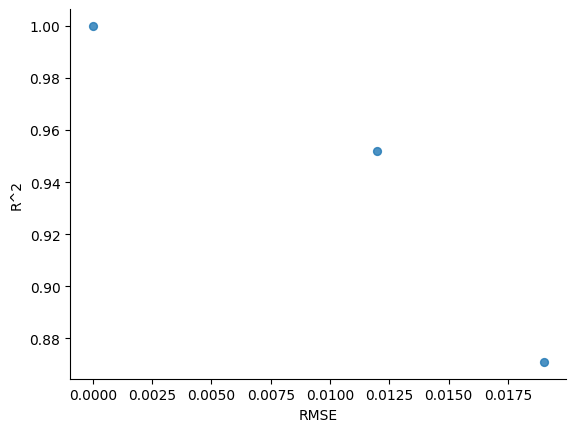

In [ ]:
# @title RMSE vs R^2

from matplotlib import pyplot as plt
final_metrics.plot(kind='scatter', x='RMSE', y='R^2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def rank_players(final_results, number_of_ranked_players):
  rank_final = pd.DataFrame()
  temp = final_results
  rank = pd.DataFrame()
  rank_real = temp.sort_values(by='MVP Votes Share', ascending=False)[:number_of_ranked_players].reset_index(drop=True)
  rank['Player'] = rank_real['Player']
  rank['MVP Share Real'] = rank_real['MVP Votes Share']

  for m in skModels:
    try:
      temp2 = temp.sort_values(by='Predicted MVP Share ' + m, ascending=False)[:number_of_ranked_players].reset_index(drop=True)
      rank['MVP Rank ' + m] = temp2['Player']
      rank['MVP Share ' + m] = round(temp2['Predicted MVP Share ' + m], 3)
    except:
        continue

    rank['Season'] = season
    rank_final = pd.concat([rank_final, rank], ignore_index=True)

    # Remove rows with any NaN values
    rank_final.dropna(inplace=True)

  return rank_final


In [ ]:
rank_final = rank_players(final_results, 3)
rank_final

,Player,MVP Share Real,MVP Rank SVM,MVP Share SVM,Season,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank Gradient Boosting,MVP Share Gradient Boosting
3,Nikola Jokić,0.875,Nikola Jokić,0.775,2021-22,Nikola Jokić,0.695,Nikola Jokić,0.875
4,Joel Embiid,0.706,Giannis Antetokounmpo,0.634,2021-22,Joel Embiid,0.576,Joel Embiid,0.706
5,Giannis Antetokounmpo,0.595,Joel Embiid,0.606,2021-22,Giannis Antetokounmpo,0.530,Giannis Antetokounmpo,0.595


# Part 4 A.

In [ ]:
#Importing the necessary librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Load the dataset
url = "https://github.com/steven-n-wilson/NBA-MVP/raw/main/data/data.csv"
data = pd.read_csv(url)

In [ ]:
# Display the first few rows of the dataset to understand its structure
print(data.head())

   Surrogate_Key             Player  Age   G  GS  MP_PERGAME  FG_PERGAME  \
0              1   Precious Achiuwa   22  73  28        23.6         3.6   
1              2       Steven Adams   28  76  75        26.3         2.8   
2              3        Bam Adebayo   24  56  56        32.6         7.3   
3              4       Santi Aldama   21  32   0        11.3         1.7   
4              5  LaMarcus Aldridge   36  47  12        22.3         5.4   

   FGA_PERGAME  FG%_PERGAME  3P_PERGAME  ...  STL_TOTAL  BLK_TOTAL  TOV_TOTAL  \
0          8.3        0.439         0.8  ...         37         41         84   
1          5.1        0.547         0.0  ...         65         60        115   
2         13.0        0.557         0.0  ...         80         44        148   
3          4.1        0.402         0.2  ...          6         10         16   
4          9.7        0.550         0.3  ...         14         47         44   

   PF_TOTAL  PTS_TOTAL  Seed       PCT  MVP Rank  MVP Vo

In [ ]:
# Summary statistics of numeric columns
print(data.describe())

       Surrogate_Key         Age           G          GS  MP_PERGAME  \
count     605.000000  605.000000  605.000000  605.000000  605.000000   
mean      303.000000   25.748760   43.038017   20.330579   18.915372   
std       174.792734    4.123068   25.818269   25.803187    9.747549   
min         1.000000   19.000000    1.000000    0.000000    1.000000   
25%       152.000000   23.000000   17.000000    0.000000   11.100000   
50%       303.000000   25.000000   48.000000    7.000000   18.100000   
75%       454.000000   28.000000   66.000000   35.000000   27.300000   
max       605.000000   41.000000   82.000000   82.000000   43.500000   

       FG_PERGAME  FGA_PERGAME  FG%_PERGAME  3P_PERGAME  3PA_PERGAME  ...  \
count  605.000000   605.000000   605.000000  605.000000   605.000000  ...   
mean     3.037025     6.722479     0.431927    0.915537     2.685785  ...   
std      2.293466     4.822415     0.142360    0.862322     2.268689  ...   
min      0.000000     0.000000     0.000000

<Figure size 1200x800 with 0 Axes>

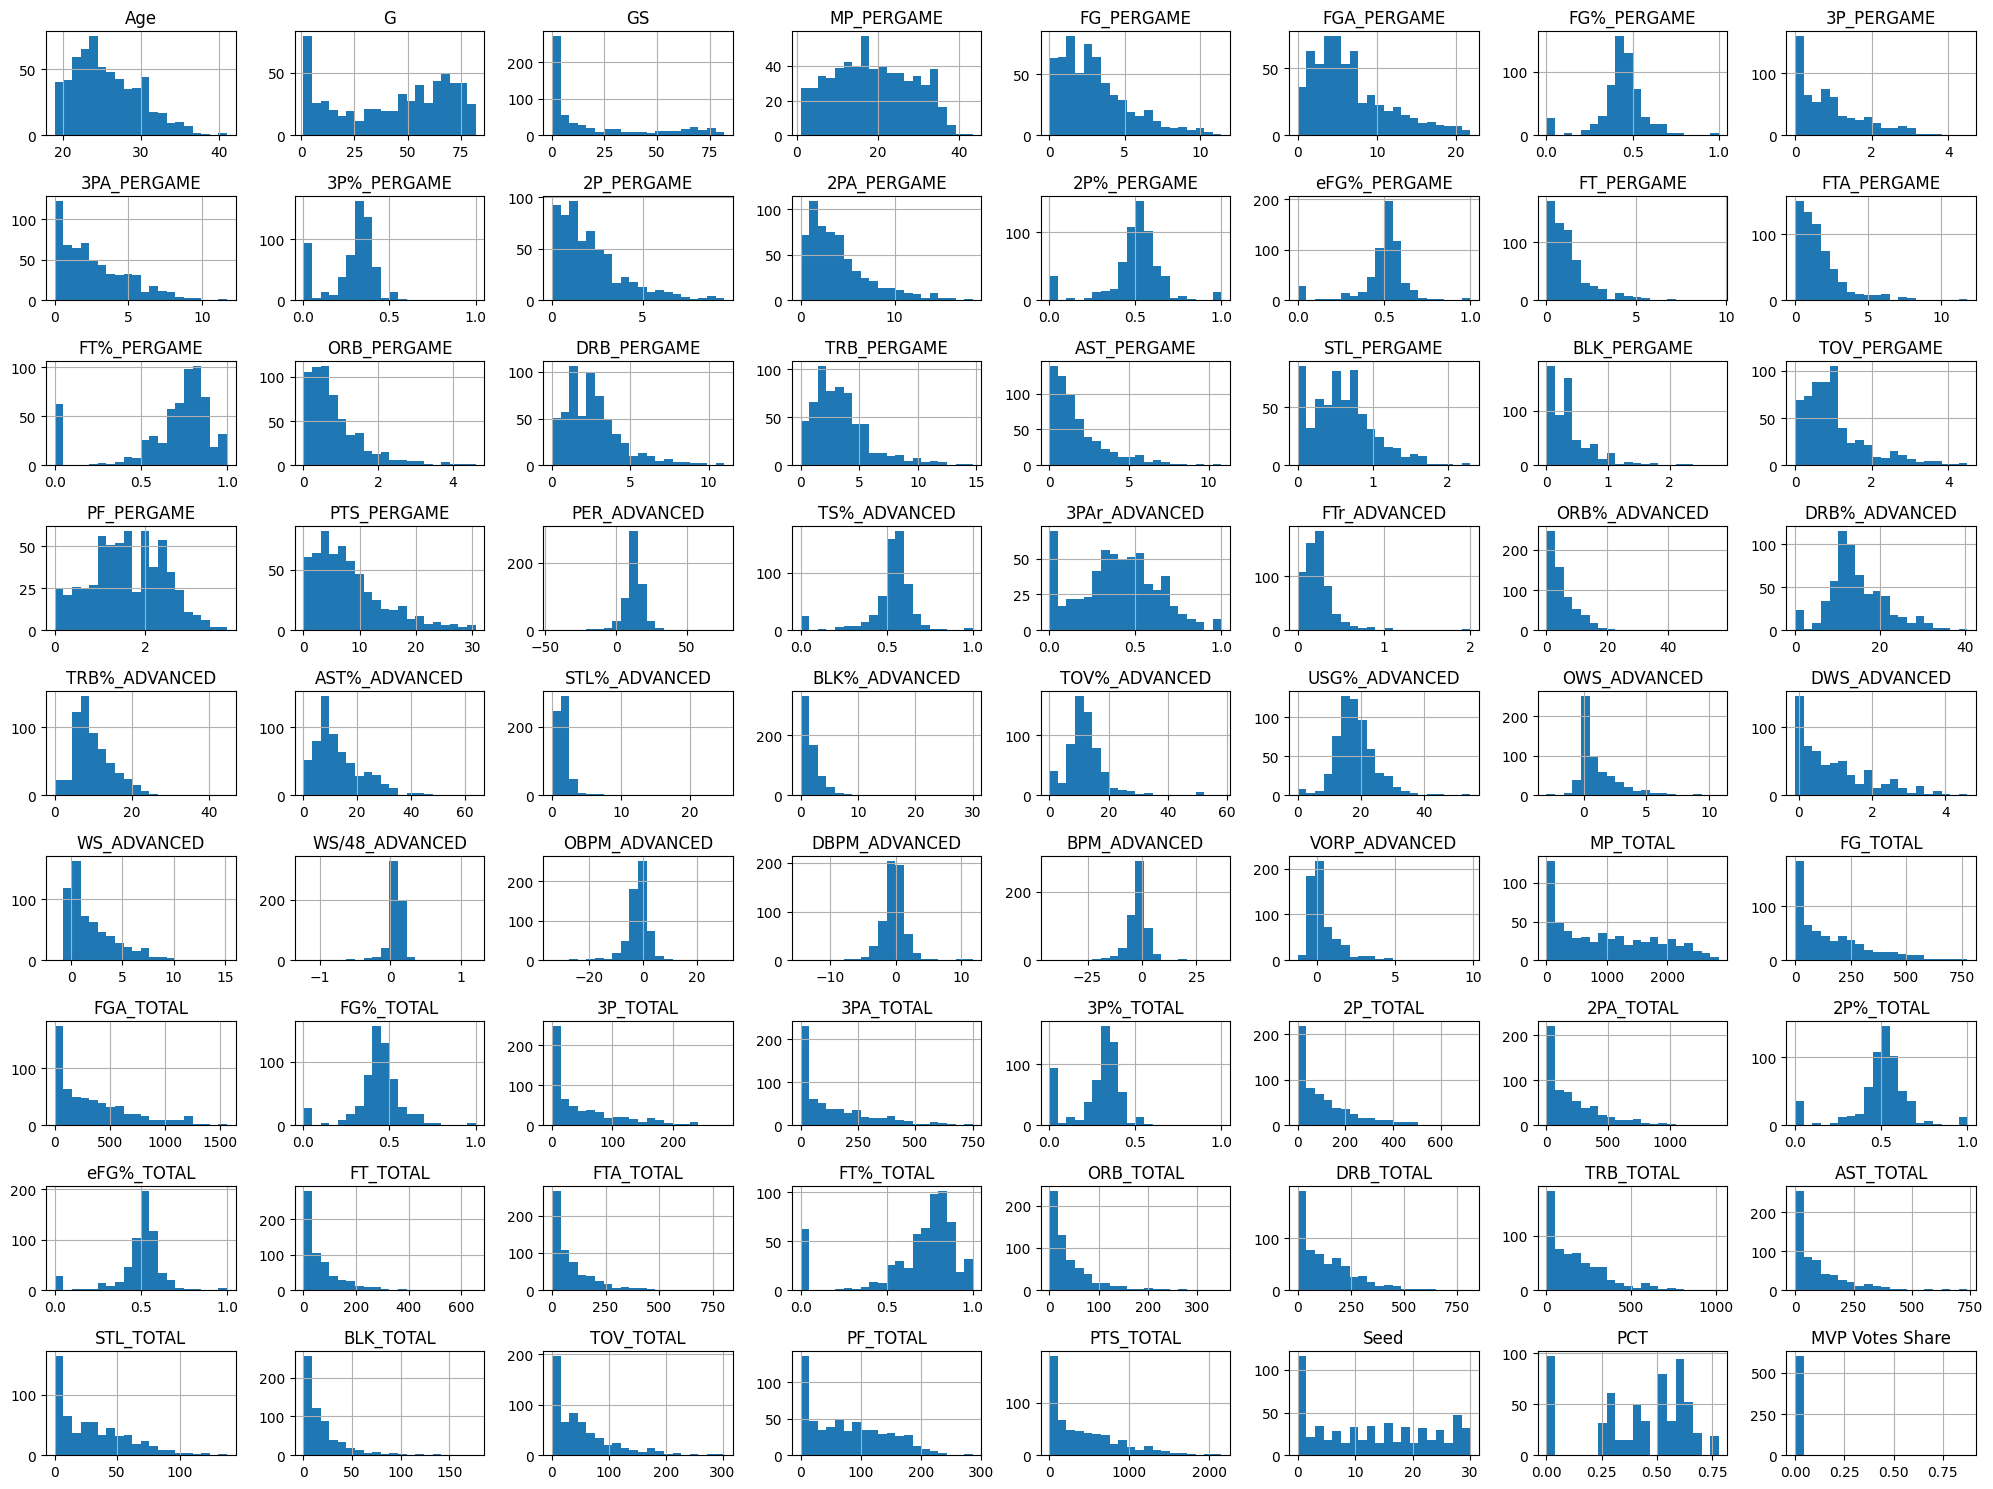

In [ ]:
# Histograms for numeric variables
plt.figure(figsize=(12, 8))
data.drop(['Surrogate_Key', 'Player', 'Season'], axis=1).hist(bins=20, figsize=(20, 15))
plt.tight_layout()
plt.show()


#Overview of values

In [ ]:
pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.1 MB/s eta 0:00:00


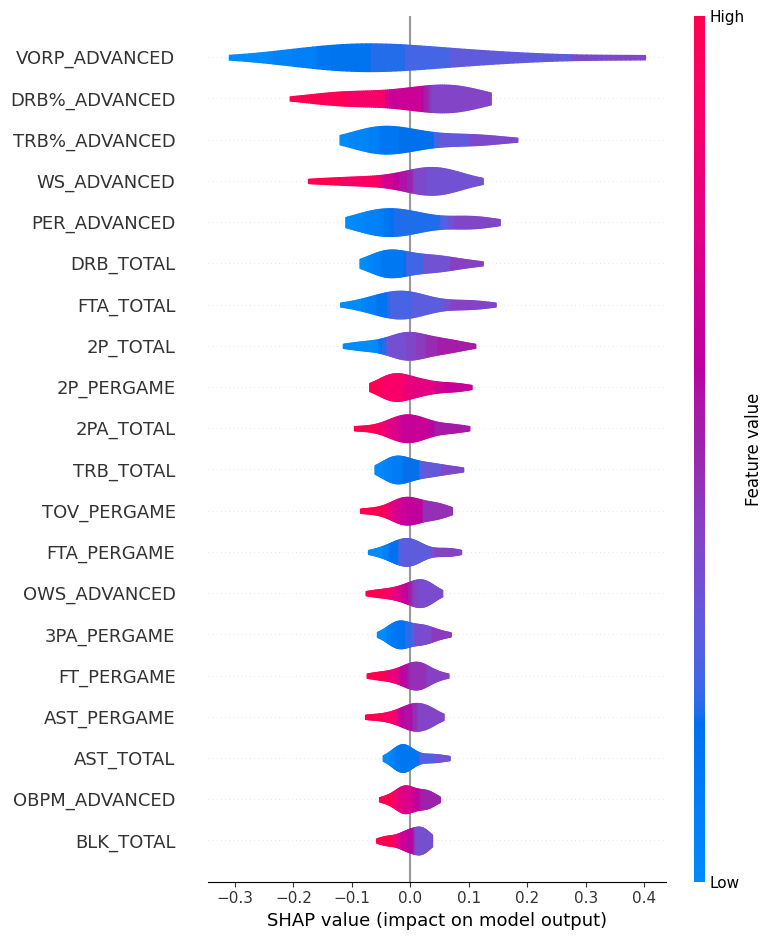

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import shap
import numpy as np

def apply_models(data, models):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []

    training_data = data
    test_data = data

    X_train = training_data.drop(['MVP Votes Share', 'MVP Rank'], axis=1)
    y_train = training_data['MVP Votes Share']

    X_test = test_data[test_data['Season'] == '2021-22'].drop(['MVP Votes Share', 'MVP Rank', 'Player', 'Season'], axis=1)
    y_test = test_data[test_data['Season'] == '2021-22']['MVP Votes Share']

    initial_results = test_data[test_data['Season'] == '2021-22'][['Player', 'Season', 'MVP Votes Share', 'MVP Rank']]
    results = initial_results.copy()

    # Exclude non-numeric columns from training and testing data
    numeric_columns = X_train.select_dtypes(include=np.number).columns.tolist()
    X_train_numeric = X_train[numeric_columns]
    X_test_numeric = X_test[numeric_columns]

    # Scale only numerical columns
    scaler = StandardScaler()
    scaled_X_train_numeric = scaler.fit_transform(X_train_numeric)
    scaled_X_test_numeric = scaler.transform(X_test_numeric)

    # Combine scaled numerical columns with non-numeric columns
    scaled_X_train = pd.DataFrame(scaled_X_train_numeric, columns=numeric_columns, index=X_train.index)
    scaled_X_test = pd.DataFrame(scaled_X_test_numeric, columns=numeric_columns, index=X_test.index)

    # Step 1: Create and train the SVR model
    svm_model = SVR(kernel='linear')
    svm_model.fit(scaled_X_train, y_train)

    # Step 2: Explain the SVR model with SHAP
    explainer = shap.Explainer(svm_model.predict, scaled_X_test)
    shap_values = explainer(scaled_X_test)

    # Step 3: Create violin plot
    shap.summary_plot(shap_values, X_test, plot_type='violin') # Top 20 variables

apply_models(data, ['SVM'])  # Call the function with SVM model only


This violin plot provides valuable insights into the importance and distribution of feature contributions to the model's predictions. The features which are most relevant in determining the MVP are clearly shown. The most valued stats are as follows:
1. Value Over Replacement Player
2. Defensive Rebound Percentage
3. Total Rebound Percentage
4. Win Shares
5. Player Efficiency Rating
6. Total Defensive Rebounds
7. Total Free Throws Attempted

The overall trend of these statistics is that they all represent values that would indicate not only that the player is well-performing, but is also played more frequently, responsible for plays that secure points as well as denying opposition points and contributing to overall team success. Players who excel in these statistics will likely be well-known and iconic and therefore more likely to receive MVP.


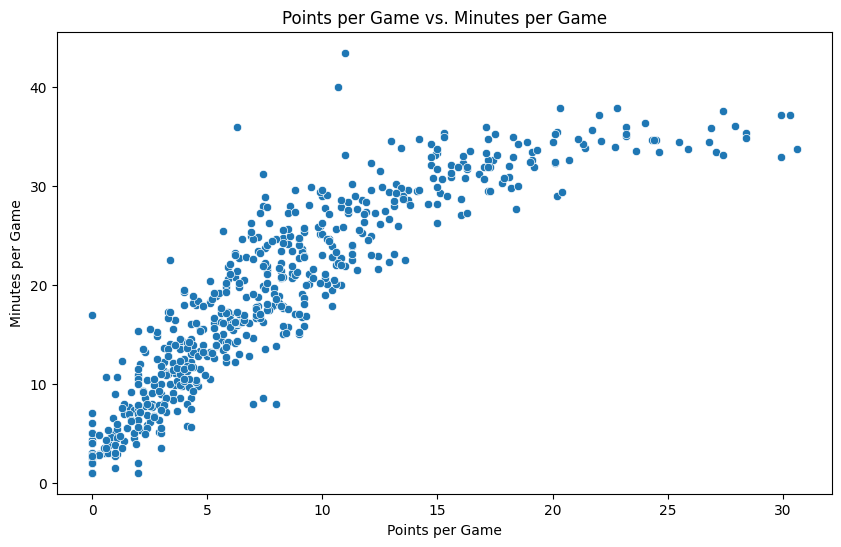

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the provided URL
url = "https://github.com/steven-n-wilson/NBA-MVP/raw/main/data/data.csv"
data = pd.read_csv(url)

# 1. Scatter Plot of Points per Game vs. Minutes per Game
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PTS_PERGAME', y='MP_PERGAME', data=data)
plt.title('Points per Game vs. Minutes per Game')
plt.xlabel('Points per Game')
plt.ylabel('Minutes per Game')
plt.show()




Players with high points per game (PPG) and minutes per game (MPG) are more likely to be MVP candidates because they consistently contribute offensively and showcase endurance. High PPG reflects their scoring prowess, while high MPG indicates their reliability and importance to the team's success. These players often lead their teams in scoring, demonstrate versatility, and show leadership on the court, making them invaluable assets. Their ability to consistently perform at a high level and positively impact their team's performance makes them strong contenders for the MVP award.

In [ ]:
sorted_data = data.sort_values(by=['PTS_PERGAME', 'MP_PERGAME'], ascending=[False, False])

# Select the top 10 players based on Points per Game and Minutes per Game
top_10_players = sorted_data.head(10)

# Display the top 10 players
print(top_10_players[['Player', 'PTS_PERGAME', 'MP_PERGAME']])

                    Player  PTS_PERGAME  MP_PERGAME
161            Joel Embiid         30.6        33.8
273           LeBron James         30.3        37.2
153           Kevin Durant         29.9        37.2
11   Giannis Antetokounmpo         29.9        32.9
140            Luka Dončić         28.4        35.4
601             Trae Young         28.4        34.9
133          DeMar DeRozan         27.9        36.1
265           Kyrie Irving         27.4        37.6
389              Ja Morant         27.4        33.1
289           Nikola Jokić         27.1        33.5


The top players for MVP votes are all within the highest performers in these aspects, showing how relevant it is in terms of determining mvp.

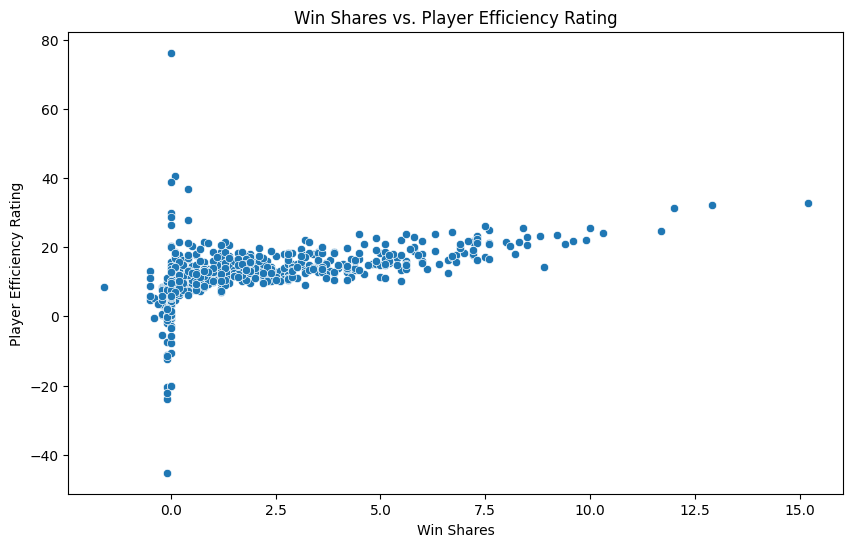

In [ ]:
# 8. Scatter Plot of Win Shares vs. Player Efficiency Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WS_ADVANCED', y='PER_ADVANCED', data=data)
plt.title('Win Shares vs. Player Efficiency Rating')
plt.xlabel('Win Shares')
plt.ylabel('Player Efficiency Rating')
plt.show()

In [ ]:
# Filter the data to include only players with over 5 minutes per game played
filtered_data = data[data['MP_PERGAME'] > 5]

# Sort the filtered dataset by Win Shares (WS_ADVANCED) and Player Efficiency Rating (PER_ADVANCED) columns in descending order
sorted_data = filtered_data.sort_values(by=['WS_ADVANCED', 'PER_ADVANCED'], ascending=[False, False])

# Select the top 10 players based on Win Shares and Player Efficiency Rating
top_10_players = sorted_data.head(10)

# Display the top 10 players with a title
print("Top 10 Players by Win Shares and Player Efficiency Rating:")
print(top_10_players[['Player', 'WS_ADVANCED', 'PER_ADVANCED']])

Top 10 Players by Win Shares and Player Efficiency Rating:
                    Player  WS_ADVANCED  PER_ADVANCED
289           Nikola Jokić         15.2          32.8
11   Giannis Antetokounmpo         12.9          32.1
161            Joel Embiid         12.0          31.2
194            Rudy Gobert         11.7          24.7
545     Karl-Anthony Towns         10.3          24.1
601             Trae Young         10.0          25.4
588        Robert Williams          9.9          22.1
525           Jayson Tatum          9.6          21.8
437             Chris Paul          9.4          20.8
86            Jimmy Butler          9.2          23.6


A player with high ratings in Win Shares and Player Efficiency Rating is more likely to receive an MVP (Most Valuable Player) award due to their significant impact on team success. Win Shares quantify a player's contribution to team wins, reflecting their overall value. Player Efficiency Rating measures a player's overall statistical contribution per minute played, indicating their efficiency. High ratings in both metrics signify a player who not only contributes significantly to their team's success but does so efficiently, making them invaluable assets and strong contenders for the MVP title.

<ipython-input-9-8ac45f9dbf5c>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='MVP Votes Share', y='Player', data=filtered_data, ci=None)


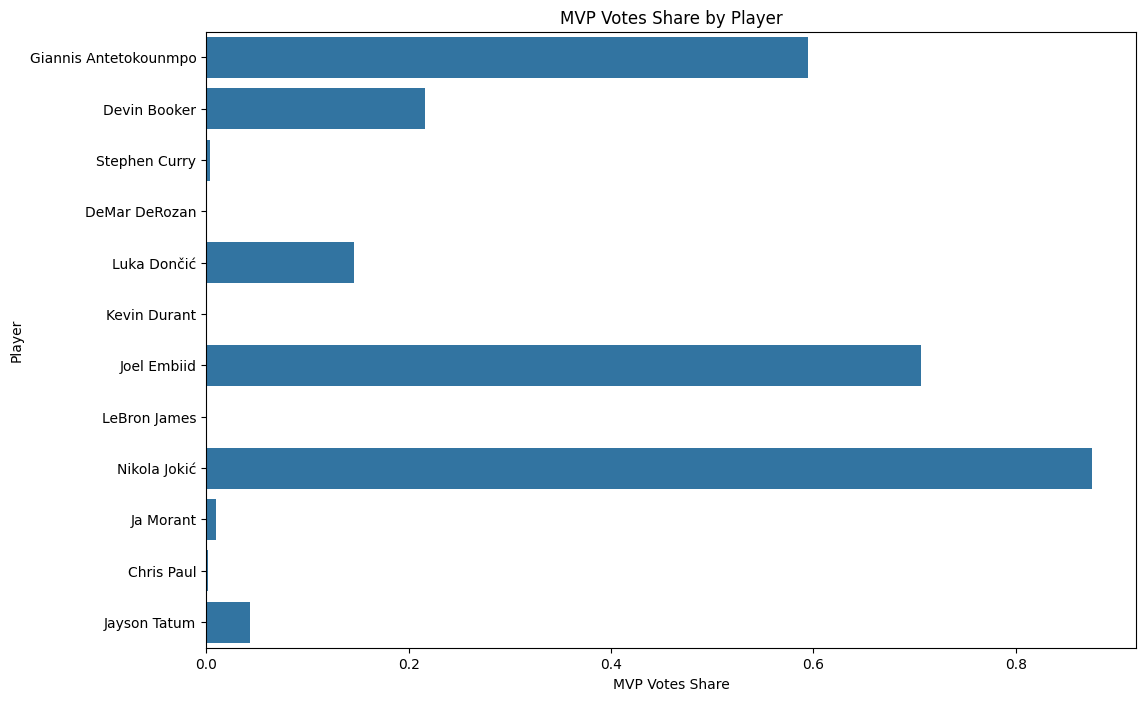

In [ ]:
# Filter the data to include only players with more than 0 MVP votes
filtered_data = data[data['MVP Votes Share'] > 0]

# Bar Chart of MVP Votes Share by Player for filtered data
plt.figure(figsize=(12, 8))
sns.barplot(x='MVP Votes Share', y='Player', data=filtered_data, ci=None)
plt.title('MVP Votes Share by Player')
plt.xlabel('MVP Votes Share')
plt.ylabel('Player')
plt.show()



Here is the actual MVP votes distribution. Here we can clearly observe which players are MVP-viable.

# Part A Summary of Preprocessing

The preprocessing of data was performed in Phase 2 of the project.
The steps to do so were as follows:
1. **Removing duplicate columns**: Some columns that are found in multiple dataframes were dropped to prepare for merging

2. **Renaming columns**: Remaned to identify the type of statistic they represent (ex:_PERGAME, _TOTAL, etc)

3. **Merging dataframes**  'per_game', 'total', and 'advanced' frames merged based on the common columns 'Player' and 'Tm' using a left join.

4. **Mapping Team Abbreviations**: A dictionary mapping NBA team names to their corresponding abbreviations was created and then used to create a dataframe.

5. **Merging Standings Data**: Standings data, including team records, is merged with the team abbreviation DataFrame based on the 'Team' column.

6. **Calculating Win Percentage**: Win percentage ('PCT') is calculated from the 'Record' column in the standings DataFrame.

7. **Merging MVP Data**: MVP data is merged into the main DataFrame based on player names.

8. **Cleaning Player Names**: Player names are cleaned by removing unnecessary characters.

9. **Removing Duplicate Players**: Duplicate player entries are removed, keeping only the first occurrence.

10. **Filtering MVP Candidates**: Two sets of filtering criteria, labeled as 'TIGHT FILTER' and 'LOOSE FILTER', are applied to identify MVP-caliber players based on various statistical thresholds and MVP vote shares.

11. **Removing Unnecessary Columns**: Columns related to team information ('Tm', 'Team', 'Record') are dropped from the DataFrame.

12. **Generating Surrogate Keys**: Sequential surrogate keys starting from 1 are generated and set as the first column of the DataFrame.